In [30]:
import pathlib
import json

# data
import xarray
import numpy as np
import pandas as pd

# plotting
import cmocean.cm
import matplotlib
import matplotlib.pyplot as plt
import osgeo.osr

# 3d
from tvtk.api  import tvtk
from mayavi import mlab


In [55]:
ds_path = pathlib.Path('~/data/odv/climatology/Water_body_Salinity_NorthSea.4Danl_monthly.nc').expanduser()
ds_path = pathlib.Path('~/data/odv/climatology/SDN_MedSea_Clim.nc').expanduser()

wgs84 = osgeo.osr.SpatialReference()
webmercator = osgeo.osr.SpatialReference()
wgs84.ImportFromEPSG(4326)
webmercator.ImportFromEPSG(3857)
wgs2wm =  osgeo.osr.CoordinateTransformation(wgs84, webmercator)

In [5]:
def attribute_names(ds, attribute='standard_name'):
    attr_by_var = {}
    for var in ds.variables:
        attrs = getattr(ds, var).attrs    
        try:
            attr_by_var[attrs[attribute]] = var
        except KeyError:
            pass
    return attr_by_var

        

    

In [6]:
ds = xarray.open_dataset(ds_path)

attribute_names(ds, 'long_name')


{'longitude': 'obslon',
 'latitude': 'obslat',
 'depth below sea level': 'obsdepth',
 'time': 'obstime',
 'sea water salinity': 'Salinity',
 'sea water salinity masked using relative error threshold 0.3': 'Salinity_L1',
 'sea water salinity masked using relative error threshold 0.5': 'Salinity_L2',
 'Relative error of sea water salinity': 'Salinity_relerr',
 'observation identifier': 'obsid'}

In [61]:
def compute_contours(ds_path, variable='Temperature', percentiles=None):
    """compute a set  of contours for a dataset"""
    ds = xarray.open_dataset(ds_path)
    ds = ds.isel(time=1)
    
    
    # guess the names 
    # not generic, but input data is not well defined
    # multiple lat/lon in one file
    # standard names not always filled in
    names = list(ds.variables)
    if 'lat' in names:
        lat_name = 'lat'
    elif 'latitude' in names:
        lat_name = 'latitude'
    if 'lon' in names:
        lon_name = 'lon'
    elif 'longitude' in names:
        lon_name = 'longitude'
    
    lat = getattr(ds, lat_name)
    lon = getattr(ds, lon_name)
    
    if 'depth' in names:
        height = -ds.depth.values
    elif 'altitude' in names:
        height = ds.altitude.values
    
    meta = {}

    arr = np.squeeze(getattr(ds, variable).values)

    var_min = np.nanmin(arr)
    var_max = np.nanmax(arr)

    q = [0.01, 0.05, 0.1, 0.25,  0.5,  0.75, 0.9, 0.95,  0.99]
    if percentiles  is None:
        percentiles = np.nanpercentile(arr, q)
    
    

    meta['variable'] = variable
    meta['var_min'] = var_min
    meta['var_max'] = var_max
    meta['percentiles'] = percentiles.tolist()

    # change dimenions  to x,y,z
    arr = np.moveaxis(arr, [0, 1, 2], [2, 1, 0])

    arr_masked = np.ma.masked_invalid(arr)
    arr_filled = arr_masked.filled(0).copy()

    Lat, Lon, Z = np.meshgrid(lat.values, lon.values, height)
    xyz = np.array(wgs2wm.TransformPoints(np.c_[Lat.ravel(), Lon.ravel()]))
    X =  xyz[:, 0].reshape(Lon.shape)
    Y =  xyz[:, 1].reshape(Lat.shape)
    
    x_min, x_max = X.min(), X.max()
    y_min, y_max = Y.min(), Y.max()
    z_min, z_max = Z.min(), Z.max()
    
    lat_min, lat_max = Lat.min(), Lat.max()
    lon_min, lon_max = Lon.min(), Lon.max()
    
    meta['x_min'] = x_min
    meta['x_max'] = x_max
    meta['y_min'] = y_min
    meta['y_max'] = y_max
    meta['z_min'] = z_min
    meta['z_max'] = z_max
    meta['lat_min'] = lat_min
    meta['lat_max'] = lat_max
    meta['lon_min'] = lon_min
    meta['lon_max'] = lon_max
    
    isos = [
        mlab.contour3d(X, Y, Z, arr_filled,  contours=[percentile])
        for percentile
        in percentiles
    ]

    contours = []
    for iso in isos:
        contour = iso.contour
        contour.minimum_contour = var_min
        contour.filled_contours = False
        contour.outputs[0].update()
        contours.append(contour.outputs[0].output)
    return meta, contours

In [62]:
meta, contours =  compute_contours(ds_path, variable='Temperature', percentiles = np.array([6, 8,  10, 12, 14, 16.0]))



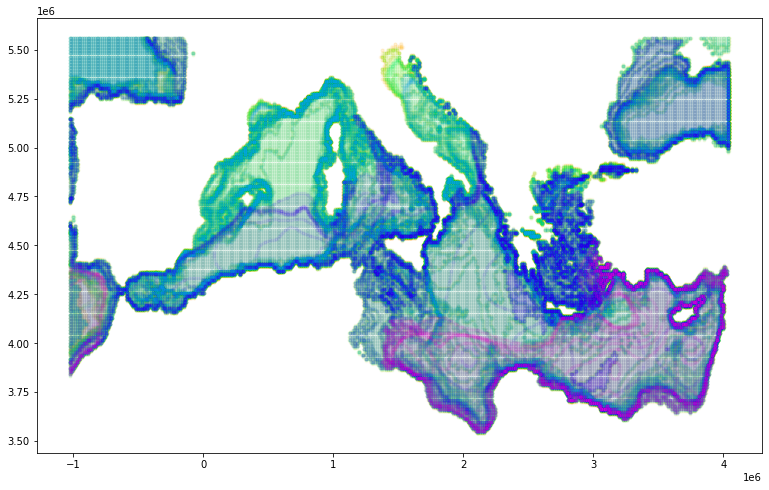

In [63]:
N = matplotlib.colors.Normalize(meta['var_min'], meta['var_max'])
colors = matplotlib.cm.hsv(N(meta['percentiles']))

fig, ax = plt.subplots(figsize=(13, 8))
for color, contour, percentile in list(zip(colors, contours, meta['percentiles'])):
    df =  pd.DataFrame(contour.points, columns=['x', 'y', 'z'])
    ax.plot(df.x, df.y, '.', alpha=0.04, color=color)

In [64]:
base_dir = ds_path.with_suffix('') 
base_dir.mkdir(exist_ok=True)

paths = []


for i, (color, contour, percentile) in enumerate(zip(colors, contours, meta['percentiles'])):
    
    smooth = tvtk.SmoothPolyDataFilter()
    smooth.relaxation_factor  = 0.01
    smooth.add_input_data_object(contour)
    smooth.update()
    
    transform_filter = tvtk.TransformFilter()
    transform = tvtk.Transform()
    x_min = meta['x_min']
    x_max = meta['x_max']
    y_min = meta['y_min']
    y_max = meta['y_max']
    z_min = meta['z_min']
    z_max = meta['z_max']
    lat_min = meta['lat_min'] 
    lat_max = meta['lat_max'] 
    lon_min = meta['lon_min'] 
    lon_max = meta['lon_max'] 

    transform.scale(1/(x_max - x_min), 1/(y_max - y_min), 1/(z_max - z_min))
    transform_filter.transform = transform
    transform_filter.add_input_data_object(smooth.output)
    transform_filter.update()
    base_path = base_dir / "polydata-{}-{:04d}".format(meta['variable'], i)
    
    ply_path = base_path.with_suffix('.ply')
    paths.append(str(ply_path.relative_to(base_dir)))
    
    writer = tvtk.PLYWriter(file_name=str(ply_path))
    writer.add_input_data_object(transform_filter.output)
    writer.update()
    writer.write()
    
meta['paths'] = paths
    
with base_path.with_suffix('.json').open('w') as f:
    pd.Series(meta).to_json(f)
    
    


In [53]:
!open  $base_dir

In [54]:
meta

{'variable': 'Salinity',
 'var_min': 16.04708,
 'var_max': 40.621155,
 'percentiles': [17.05020319328308,
  22.63753060722351,
  25.287433624267578,
  29.111615142822263,
  31.48705137252808,
  32.052745208740234,
  32.32432250976562,
  32.4031077003479,
  32.44609582977295],
 'x_min': -445277.96317309426,
 'x_max': 1113194.9079327357,
 'y_min': 6190443.809135445,
 'y_max': 8859142.800565697,
 'z_min': -700.0,
 'z_max': -0.0,
 'lat_min': 48.5,
 'lat_max': 62.0,
 'lon_min': -4.0,
 'lon_max': 10.0,
 'paths': ['polydata-Salinity-0000.ply',
  'polydata-Salinity-0001.ply',
  'polydata-Salinity-0002.ply',
  'polydata-Salinity-0003.ply',
  'polydata-Salinity-0004.ply',
  'polydata-Salinity-0005.ply',
  'polydata-Salinity-0006.ply',
  'polydata-Salinity-0007.ply',
  'polydata-Salinity-0008.ply']}

'{"variable":"Salinity","var_min":16.0470790863,"var_max":40.6211547852,"percentiles":[17.0502031933,22.6375306072,25.2874336243,29.1116151428,31.4870513725,32.0527452087,32.3243225098,32.4031077003,32.4460958298],"x_min":-445277.9631730943,"x_max":1113194.9079327357,"y_min":6190443.8091354454,"y_max":8859142.8005656973,"z_min":-700.0,"z_max":0.0,"lat_min":48.5,"lat_max":62.0,"lon_min":-4.0,"lon_max":10.0}'